## Work
請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization, Dropout

class Model():
    def __init__(self):
        # Hyperparameters
        self.__HypPara = {}
        
        # Model Parameters
        self.__ModelPara = {}
        
        # Model Data
        self.__ModleData = {}
        
        self.var_name = None
        self.results = {}
    
    def setHypPara(self, **HypPara):
        HypPara_list = ['lr', 'epochs', 'momentum', 'batch_size', 'dropout']
        for i, name in enumerate(HypPara_list):
            self.__HypPara[name] = HypPara[name]
    
    def setModelPara(self, **ModelPara):
        ModelPara_list = ['output_size', 'num_neurons', 'regularizers_type', 'regularizers_value', 'BNAFInput', 'BNBFHidden', 'BNAFHidden']
        for i, name in enumerate(ModelPara_list):
            self.__ModelPara[name] = ModelPara[name]
    
    def setModelData(self, **ModelData):
        data_name_list = ['train_input', 'train_target', 'test_input', 'test_target']
        for i, name in enumerate(data_name_list):
            self.__ModleData[name] = ModelData[name]
    
    def setVarName(self, VarName):
        self.VarName = VarName
    
    def build_mlp(self):
        keras.backend.clear_session() # 把舊的 Graph 清掉
        
        try:
            input_shape = self.__ModleData['train_input'].shape[1:]
        except:
            print("Model parameters is unsetting.")
        
        input_layer = keras.layers.Input(input_shape)
        
        for i, n_units in enumerate(self.__ModelPara['num_neurons']):
            if i == 0 and self.__ModelPara['BNAFInput'] is False:
                input_data = input_layer
            elif i == 0 and self.__ModelPara['BNAFInput'] is True:
                input_data = BatchNormalization()(input_layer)
            
            if i != 0 and self.__ModelPara['BNBFHidden'] is True:
                input_data = BatchNormalization()(input_data)
            
            input_data = keras.layers.Dense(units=n_units, activation='relu', name='Hidden_Layer' + str(i + 1))(input_data)
            
            if self.__ModelPara['BNAFHidden'] is True:
                input_data = BatchNormalization()(input_data)
            
            input_data = Dropout(self.__HypPara['dropout'])(input_data)
        
        out = keras.layers.Dense(units=self.__ModelPara['output_size'],
                                 activation='softmax',
                                 kernel_regularizer=self.__ModelPara['regularizers_type'](self.__ModelPara['regularizers_value']),
                                 name="output")(input_data)
        
        self.__model = keras.models.Model(inputs=[input_layer], outputs=[out])
        self.__model.summary()
        
        return self.__model
    
    def __creatOptimizer(self):
        optimizer = keras.optimizers.SGD(lr=self.__HypPara['lr'], momentum=self.__HypPara['momentum'], nesterov=True)
        self.__model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    
    def train_model(self):
        self.__creatOptimizer()
        self.__model.fit(self.__ModleData['train_input'], self.__ModleData['train_target'],
                        epochs=self.__HypPara['epochs'],
                        batch_size=self.__HypPara['batch_size'],
                        validation_data=(self.__ModleData['test_input'], self.__ModleData['test_target']),
                        verbose=False,
                        shuffle=True)
        self.__logResults()
        
    def __logResults(self):
        train_loss = self.__model.history.history['loss']
        valid_loss = self.__model.history.history['val_loss']
        train_acc = self.__model.history.history['acc']
        valid_acc = self.__model.history.history['val_acc']
        
        self.results[self.VarName] = {'train-loss': train_loss,
                                      'valid-loss': valid_loss,
                                      'train-acc': train_acc,
                                      'valid-acc': valid_acc
                                     }

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

def plotResults(results):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    for i, cond in enumerate(results):
        plt.plot(range(len(results[cond]['train-loss'])), results[cond]['train-loss'], '-', label=cond + '-train-loss')
        plt.plot(range(len(results[cond]['valid-loss'])), results[cond]['valid-loss'], '--', label=cond +'-valid-loss')
    plt.title('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for i, cond in enumerate(results):
        plt.plot(range(len(results[cond]['train-acc'])), results[cond]['train-acc'], '-', label=cond +'-train-acc')
        plt.plot(range(len(results[cond]['valid-acc'])), results[cond]['valid-acc'], '--', label=cond +'-valid-acc')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [7]:
# Loading packapge
from keras.regularizers import l1, l2, l1_l2

In [8]:
## 超參數設定
model_HypPara = {
    'lr': 0.001,
    'epochs': 50,
    'momentum': 0.95,
    'batch_size': 256,
    'dropout': 0.2,
}

model_Para = {
    'output_size': 10,
    'num_neurons':[512, 256, 64, 32],
    'regularizers_type': l2,
    'regularizers_value': 1e-8, 
    'BNAFInput': False,
    'BNBFHidden': False,
    'BNAFHidden': False,
}

model_Data = {
    'train_input': x_train,
    'train_target': y_train,
    'test_input': x_test,
    'test_target': y_test
}

In [19]:
# Case 1 - Testing by Using Different Batch Size.
batch_size_list = [64, 128, 256]
VarName = 'batch_size'

# 建立 model
model = Model()

for batch_size in batch_size_list:
    model_HypPara['batch_size'] = batch_size
    model.setHypPara(**model_HypPara)
    model.setModelData(**model_Data)
    model.setModelPara(**model_Para)
    
    model.VarName = VarName + str(-batch_size)
    
    model.build_mlp()
    model.train_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
Hidden_Layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
Hidden_Layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
__________

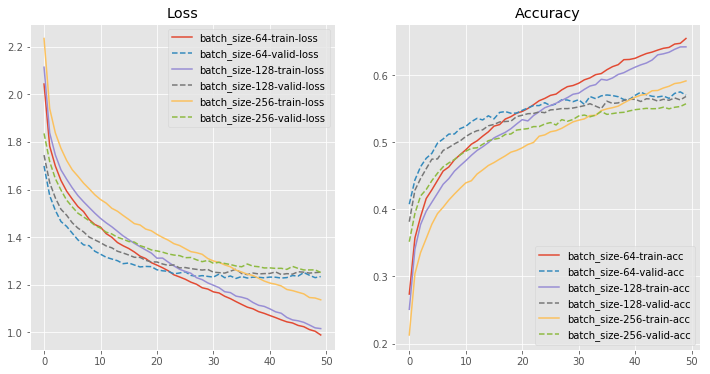

In [26]:
plotResults(model.results)

In [15]:
# Case 2 - Testing by Using Different Dropout Rates.
model_HypPara['batch_size'] = 64
dropout_list = [0.2, 0.4, 0.6]
VarName = 'dropout'
model = Model()

for dropout in dropout_list:
    model_HypPara['dropout'] = dropout
    model.setHypPara(**model_HypPara)
    model.setModelData(**model_Data)
    model.setModelPara(**model_Para)
    
    model.VarName = VarName + str(-dropout)
    
    model.build_mlp()
    model.train_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
Hidden_Layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
Hidden_Layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
__________

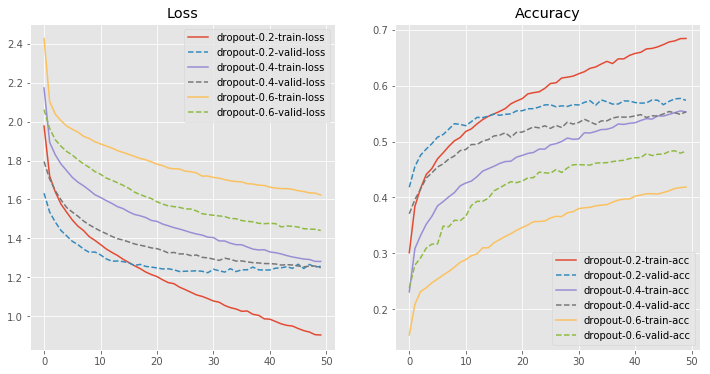

In [16]:
plotResults(model.results)

In [17]:
# case 3 - Adding BN after Input Layer and Hidden Layer
model_Para['BNAFInput'] = True
model_Para['BNAFHidden'] = True
VarName = 'BNAF-Input_Hidden'
model_HypPara['dropout'] = 0.2

model = Model()

model.setHypPara(**model_HypPara)
model.setModelData(**model_Data)
model.setModelPara(**model_Para)
    
model.VarName = VarName + ':True'
    
model.build_mlp()
model.train_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
Hidden_Layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
Hidden_Layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
__________

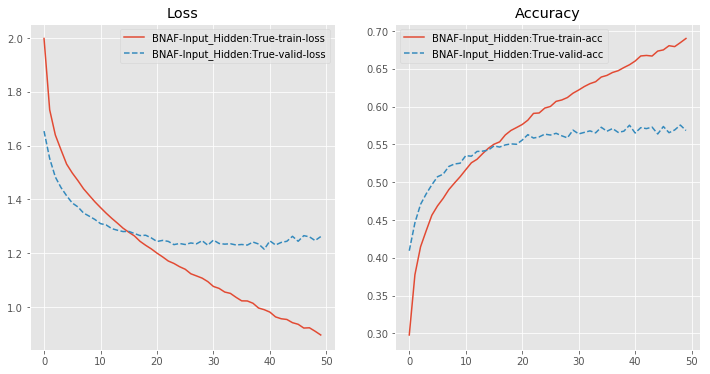

In [18]:
plotResults(model.results)

In [19]:
# case 4 - Testing by Using Different Regularizer Values.
regularizers_value_list = [1e-2, 1e-5, 1e-8]
VarName = 'regularizers'

model = Model()

for regularizers_value in regularizers_value_list:
    model_Para['regularizers_value'] = regularizers_value
    model.setHypPara(**model_HypPara)
    model.setModelData(**model_Data)
    model.setModelPara(**model_Para)
    
    model.VarName = VarName + str(-regularizers_value)
    
    model.build_mlp()
    model.train_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
Hidden_Layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
Hidden_Layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
__________

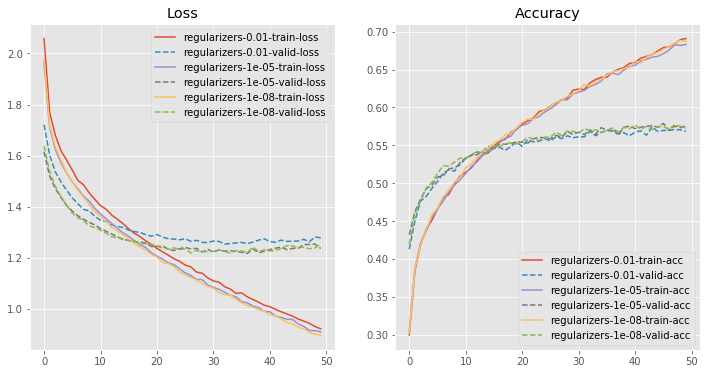

In [20]:
plotResults(model.results)

# Conclusion
* 從上面的幾個例子來看，可以發現幾個趨勢：
* 1. Batch size 使用越小的數值效果越好。
* 2. Dropout 使用越小的數值，效果越好。
* 3. 有使用 BN 效果會比較好，但是差異不大。
* 4. 有無使用 Regularizer 的差異不大。

* 因此重要性的排序是：Batch size > Dropout > BN > Regularizer.